# Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
np.random.seed(37)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('home_data_clean.csv')
df.drop(['Unnamed: 0', 'url'], axis=1, inplace=True)
df = df[(df['city'] != 'La Puente') | (df['city'] != 'Upland')]

Drop outliers

In [4]:
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1
df.drop(df[(df['price'] < (Q1 - 1.5*IQR)) | (df['price'] > (Q3 + 1.5*IQR))].index, axis=0, inplace=True)
df.reset_index(inplace=True)
print(f'Drops records where price is below {Q1 - 1.5*IQR} and above {Q3 + 1.5*IQR}')

Drops records where price is below -228881.25 and above 1997328.75


## 1. Determine Highest-Performing Model

In [5]:
def get_model(name, features, dummies=None):
    X = df[features]
    y = df['price']
    if dummies != None:
        X = pd.get_dummies(data=X, columns=dummies, dtype=int, drop_first=True)

    r2s = []
    r2_adjs = []
    RMSEs = []
    aics = []
    bics = []
    for i in range(1000):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        lr = LinearRegression()
        lr.fit(x_train, y_train)
        r2 = lr.score(x_test, y_test)
        predicted = lr.predict(x_test)
        RMSE = mean_squared_error(y_test, predicted, squared=False)
        n = x_test.shape[0]
        P = x_test.shape[1]
        r2_adj = 1 - (1 - r2) * (n - 1)/(n - P - 1)
        r2s.append(r2)
        RMSEs.append(RMSE)
        r2_adjs.append(r2_adj)

        x_test
        results = sm.OLS(y, X).fit()
        aic = results.aic
        bic = results.bic
        aics.append(aic)
        bics.append(bic)

    mean_r2 = np.mean(np.array(r2s))
    mean_RMSE = np.mean(np.array(RMSEs))
    mean_r2_adj = np.mean(np.array(r2_adjs))
    mean_aic = np.mean(np.array(aics))
    mean_bic = np.mean(np.array(bics))        
    
    models.loc[name, 'R^2'] = round(mean_r2, 4)
    models.loc[name, 'RMSE'] = round(mean_RMSE/100)*100
    models.loc[name, 'R^2-adj'] = round(mean_r2_adj, 4)
    models.loc[name, 'AIC'] = round(mean_aic)
    models.loc[name, 'BIC'] = round(mean_bic)

#### Fit & Score Linear Models

In [6]:
models = pd.DataFrame()

get_model('sqft', ['home_sqft'])
get_model('sqft-lot', ['home_sqft', 'lot_sqft'])
get_model('sqft-baths-beds', ['home_sqft', 'baths', 'beds'])
get_model('sqft-type', ['home_sqft', 'type'], ['type'])
get_model('sqft-baths-beds-type', ['home_sqft', 'baths', 'beds', 'type'], ['type'])
get_model('sqft-type-year', ['home_sqft', 'type', 'year_built'], ['type'])
get_model('sqft-type-city', ['home_sqft', 'type', 'city'], ['type', 'city'])
get_model('sqft-type-year-city', ['home_sqft', 'type', 'year_built', 'city'], ['type', 'city'])
get_model('sqft-type-year-zip', ['home_sqft', 'type', 'year_built', 'zip'], ['type'])
get_model('sqft-type-year-zip_d', ['home_sqft', 'type', 'year_built', 'zip'], ['type', 'zip'])
get_model('all', df.drop(columns=['price']).columns, ['type', 'city'])

models[['RMSE', 'AIC', 'BIC']] = models[['RMSE', 'AIC', 'BIC']].astype(int)
models.sort_values(['R^2', 'R^2-adj'], ascending=False)

,R^2,RMSE,R^2-adj,AIC,BIC
sqft-type-year-zip_d,0.9188,112800,0.8801,8176,8251
sqft-baths-beds-type,0.9125,118000,0.9013,8240,8266
sqft-type-year-city,0.9119,118100,0.8837,8201,8258
sqft-type-year-zip,0.9117,118100,0.9005,8202,8228
sqft-type-year,0.9107,118500,0.9011,8204,8226
sqft-type-city,0.9107,118400,0.8847,8233,8285
sqft-type,0.9101,118700,0.9023,8275,8293
all,0.7236,182100,0.5920,8170,8245
sqft-baths-beds,0.6927,222100,0.6771,8594,8606
sqft,0.6817,225300,0.6765,8610,8614


### Best Models: Conclusions

Different models scored highest on different metrics. It is, therefore, difficult to determine what the "best" model was.
- The model trained on **'home_sqft', 'type', 'year', 'zip'** had:  
a. the highest R-squared value **(0.9188)** and  
b. the second lowest AIC value **(8176)**, but also  
c. a relatively low adjusted R-squared value **(0.8801)** due to the number of zip codes used as dummy predictor variables.
- The simplest model trained on **'home_sqft', 'type'** had the highest adjusted R-squared value **(0.9023)**.

## 2. Analyze One High-Performing Model  
We will choose one model to analyze and improve.

### a. Get Initial Metrics

#### 'home_sqft', 'type', 'year_built', 'zip'

In [7]:
X = pd.get_dummies(data=df[['home_sqft', 'type', 'year_built', 'zip']], columns=['type', 'zip'], dtype=int, drop_first=True)
y = df['price']

r2s = []
r2_adjs = []
RMSEs = []
aics = []
bics = []
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    r2 = lr.score(x_test, y_test)
    predicted = lr.predict(x_test)
    RMSE = mean_squared_error(y_test, predicted, squared=False)
    n = x_test.shape[0]
    P = x_test.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1)/(n - P - 1)
    r2s.append(r2)
    RMSEs.append(RMSE)
    r2_adjs.append(r2_adj)

    x_test
    results = sm.OLS(y, X).fit()
    aic = results.aic
    bic = results.bic
    aics.append(aic)
    bics.append(bic)

mean_r2 = np.mean(np.array(r2s))
mean_RMSE = np.mean(np.array(RMSEs))
mean_r2_adj = np.mean(np.array(r2_adjs))
mean_aic = np.mean(np.array(aics))
mean_bic = np.mean(np.array(bics))

metrics_table = pd.DataFrame()
metrics_table['Initial'] = [round(mean_r2, 3), round(mean_RMSE/1000)*1000, round(mean_r2_adj, 3), round(mean_aic), round(mean_bic)]
metrics_table.index = models.columns
metrics_table

,Initial
R^2,0.918
RMSE,113000.000
R^2-adj,0.879
AIC,8176.000
BIC,8251.000


#### Get regression coefficients

In [8]:
coefs_table = pd.DataFrame()
coefs_table['Initial'] = np.insert(lr.coef_, 0, lr.intercept_)
coefs_table.index = np.insert(X.columns, 0, 'intercept')

### b. Analyze Residuals

In [9]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

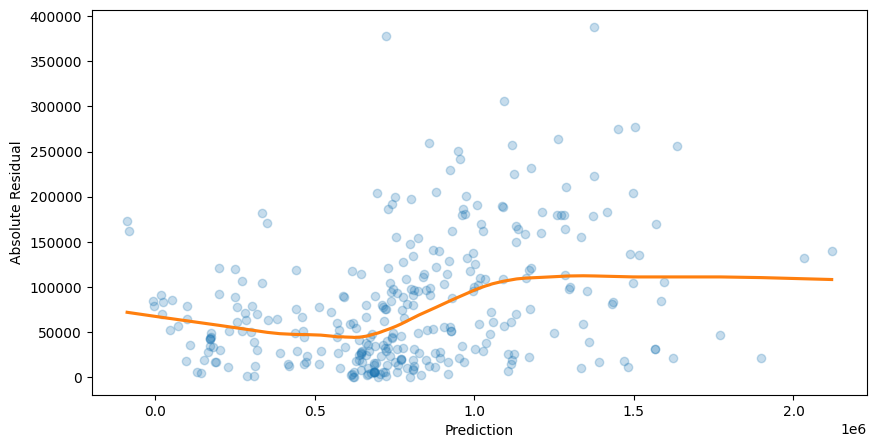

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(x=results.fittedvalues, y=np.abs(results.resid), scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Absolute Residual')
ax.set_label('View of Potential Heterskedasticity')
plt.show()

The variance of the absolute residual values are noticeably greater for predictions above about $1 million.  
The model may not account for certain important features in higher value homes.  
Let us examine the partial residual plot for 'home_sqft' to determine whether it predicts the outcome equally well for the entire range.

#### Partial Residual Plot

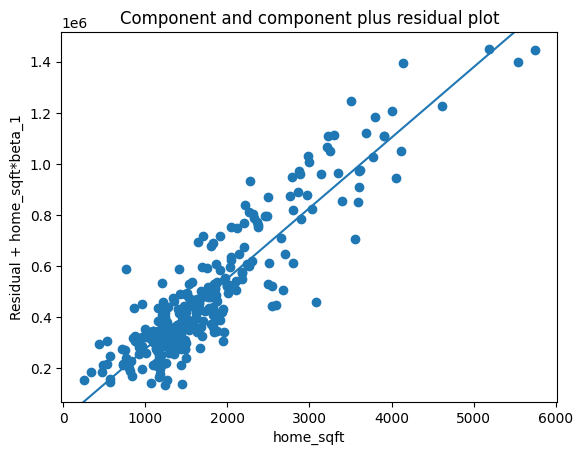

In [11]:
sm.graphics.plot_ccpr(results, 'home_sqft')
plt.show()

This partial residual plot indicates that the term 'home_sqft' predicts the data well for the entire range of values.

#### Influence Plot

In [12]:
influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal

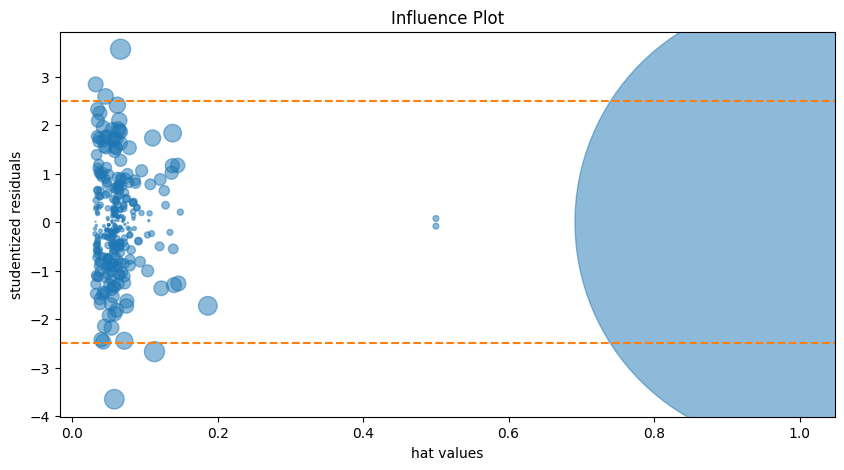

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, sresiduals, s=1000 * np.sqrt(influence.cooks_distance[0]), alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')
ax.set_title('Influence Plot')
plt.show()

- Two records are potential outliers, having absolute studentized residual values greater than 3
- There is one record that has an unrealistically high Cook's distance.

These records will be dropped.

#### Drop outliers (records with high studentized residual values)

In [14]:
high_resids = sresiduals[np.abs(sresiduals) > 3]
high_resids

161    3.571635
280   -3.651208
dtype: float64

In [15]:
X.drop(high_resids.index, inplace=True)
y.drop(high_resids.index, inplace=True)

#### Drop highly influential values (records with high Cook's distances)

In [16]:
cooks = influence.cooks_distance[0]
infls = cooks[cooks > 0.08]
infls

9    10932.739957
dtype: float64

In [17]:
X.drop(infls.index, inplace=True)
y.drop(infls.index, inplace=True)

### c. Get Final Metrics

In [18]:
r2s = []
r2_adjs = []
RMSEs = []
aics = []
bics = []
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    r2 = lr.score(x_test, y_test)
    predicted = lr.predict(x_test)
    RMSE = mean_squared_error(y_test, predicted, squared=False)
    n = x_test.shape[0]
    P = x_test.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1)/(n - P - 1)
    r2s.append(r2)
    RMSEs.append(RMSE)
    r2_adjs.append(r2_adj)

    x_test
    results = sm.OLS(y, X).fit()
    aic = results.aic
    bic = results.bic
    aics.append(aic)
    bics.append(bic)

mean_r2 = np.mean(np.array(r2s))
mean_RMSE = np.mean(np.array(RMSEs))
mean_r2_adj = np.mean(np.array(r2_adjs))
mean_aic = np.mean(np.array(aics))
mean_bic = np.mean(np.array(bics))

metrics_table['Final'] = [round(mean_r2, 3), round(mean_RMSE/1000)*1000, round(mean_r2_adj, 3), round(mean_aic), round(mean_bic)]
metrics_table

,Initial,Final
R^2,0.918,0.926
RMSE,113000.000,108000.000
R^2-adj,0.879,0.887
AIC,8176.000,8066.000
BIC,8251.000,8140.000


By dropping the outliers/influential records, every metric improved slightly.

In [19]:
lr.coef_ = lr.coef_[1:]
coefs_table['Final'] = np.insert(lr.coef_, 0, lr.intercept_)
coefs_table

,Initial,Final
intercept,-1.772653e+06,-2.204233e+06
home_sqft,2.681786e+02,2.841647e+02
year_built,9.962708e+02,1.194737e+03
type_MANUFACTURED,-3.861568e+05,-3.743940e+05
type_MULTI_FAMILY,3.054652e+05,2.811692e+05
type_SINGLE_FAMILY,2.360359e+05,2.454531e+05
type_TOWNHOUSE,-1.236870e+04,-1.472507e+04
zip_91706,-2.375971e+04,-1.287586e+04
zip_91711,5.048651e+04,9.542493e+04
zip_91722,-2.581502e+03,2.705711e+03
